In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import some_routines as sr

# 2. Making an initial density field

#### Generate a Fourier plane. This can be done by generating a 2D matrix with complex entries, of which the real and imaginary parts may just be normal random numbers with mean zero and variance given by the power spectrum. Assume $$P(k) \propto k^n.$$ 

#### The matrix that is constructed is required to have certain symmetries such that after the IFFT, the matrix is real. This mean that we have the symmetry $\tilde{Y}(-k) = \tilde{Y}*(k).$ Using this information you can make a Gaussian random field. Make plots of three Gaussian random fields, using n=-1, n=-2 and n=-3. Give the plots a size of 1024x2014 pixels. The axis should be in physical size (e.g., Mpc). Choose a minimum physical size and explain how this impacts the maximum physical size, the minimum $k$ and maximum $k$

The (1D) inverse discrete Fourier transform can be written as
\begin{equation}
f(n) = \sum_{j=0}^{N-1} \hat(f) e^{i \frac{2\pi}{N} jn}
\end{equation}
where $n$ runs from $0$ to $N-1$ and we have not defined a normalization. In this case, $n$ can be thought of as the indices of the function $f$, which is sampled at $f(0),..,f(N-1)$

The mapping from integer $j$ to wave number $k$ is as follows
\begin{equation}
k = \frac{2\pi}{N} j
\end{equation}
For $-N/2 \leq j \leq N/2$.

Working with indices, it is most convenient to let $j$ run from $0$ to $N-1$, this corresponds to 
$$k=0,\frac{2\pi}{N},\frac{4\pi}{N},...,\frac{2\pi}{N}\times \frac{N}{2}, \frac{2\pi}{N}\left(-\frac{N}{2}+1\right),...,\frac{2\pi}{N}(-1) $$

Since we only have to generate the upper half of the Fourier plane, and $N=1024$ is an even number we can let our two indices run from $N/2=512$ to generate the upper half of the Fourier plane. Additionally, since the x-axis in the Fourier plane also consists of complex conjugates symmetric in $x$, we only have to generate half of the x-axis as well.

In [9]:
# We only have to generate the upper half of the fourier plane
# since the lower half will be given by the complex conjugate 
# because the field has to be real. Similary, for ky=0
# we have that opposite kx's will be complex conjugates.
def model_n(k, n):
    return k**n

def density_field(N, model, randgauss):
    """
    Generate a real density field with mean 0
    that follows a given power spectrum model.
    
    N         -- int: size of the field
    model     -- Power spectrum model function of k
    randgauss -- N**2 standard normal numbers for quick construction
    """
    
    fftfield = np.zeros((N,N),dtype='complex')
    # One step in k
    dk = 2*np.pi/N 
    # The fourier frequencies are different for (un)even N
    Neven = N%2 # add one to loops if N is uneven
    
    counter = 0
    # Loop over all kx modes
    for i in range(0,N): 
        if i <= N//2:
            kx = dk*i
        else:
            kx = (-N+i)*dk
            
        # start at j=1 because we generate the kx's on the 
        # ky=0 -axis seperately. Additionally, only generate the 
        # upper half of the fourier plane (ky>0)
        for j in range(1,N//2+Neven):
            ky = dk*j               
            k = (kx**2+ky**2)**0.5
#             Transform standard normal numbers to correct variance.
#             Since these modes will be conjugated and put into the
#             lower half of the Fourier plane, we have to divide the
#             variance by 2 in order to satisfy total variance being
#             equal to P(k) at k=k
            fftfield[i,j] = randgauss[counter]*(model(k)/2)**0.5 + 1j*(
                            randgauss[counter+1]*(model(k)/2)**0.5)
            counter += 2
    if Neven == 0:
        # We have an even amount of N, so do not forget the N//2
        # column
        ky = N//2*dk
        for i in range(1,N//2):
            kx = dk*i
            k = (kx**2+ky**2)**0.5
            # Note again division by two of the variance.
            fftfield[i,N//2] = randgauss[counter]*(model(k)/2)**0.5 +1j*(
                               randgauss[counter+1]*(model(k)/2)**0.5)
            counter += 2
            # Complex conjugate
            fftfield[-i,N//2] = fftfield[i,N//2].real - 1j*(
                                fftfield[i,N//2].imag)
            
        # Now some numbers are their own complex conjugate.
        # i.e., they are real. No dividing by two of the variance.
        k = (N//2*dk)
        fftfield[0,N//2] = randgauss[counter+1]*model(k)**0.5 + 1j*0
        fftfield[N//2,0] = randgauss[counter+2]*model(k)**0.5 + 1j*0
        k *= np.sqrt(2)
        fftfield[N//2,N//2] = randgauss[counter+3]*model(k)**0.5 + 1j*0
        counter += 3
        
    # The kx-axis is conjugate symmetric in kx
    # so we only have to generate half of this axis 
    for i in range(1,N//2+Neven):
        fftfield[i,0] = randgauss[counter]*(model(k)/2)**0.5 + 1j*(
                            randgauss[counter+1]*(model(k)/2)**0.5)
        counter += 2
        # complex conjugate
        fftfield[-i,0] = fftfield[i,0].real - 1j*fftfield[i,0].imag
        
        
    # Finally generate all modes below the kx axis by conjugating
    # all modes above the kx axis 
    for i in range(0,N):
        for j in range(N//2,N):
            fftfield[i,j] = fftfield[-i,-j].real - 1j*fftfield[-i,-j].imag
    
    # Don't forget that the [0,0] component of the field has to be 0
    # for a GRF with mean 0
    fftfield[0,0] = 0 + 1j*0
    
    # Multiply by N^2 to undo the normalization build into scipy
    densfield = scipy.fftpack.ifft2(fftfield)*N**2
    
    return fftfield, densfield
            
            

In [11]:
# use the more than 1 million random numbers we generated before
randgauss = np.load('./1MrandSN.npy')

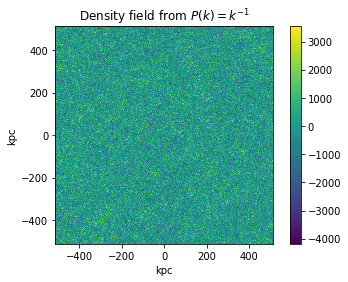

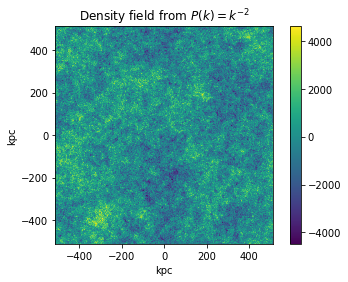

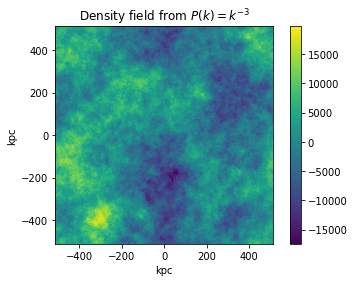

In [12]:
# We can assign our own scale, since the power spectrum is a simple
# power law. Thus we assume here one pixel is one Kpc
for n in [-1,-2,-3]:
    # Power spectrum power law
    model = lambda k: model_n(k,n)
    fftfield, densfield = density_field(1024,model,randgauss)    

    plt.title(f"Density field from $P(k)=k^{ {n} }$")
    # Fix that center x,y = (0,0) in the middle of the plot
    plt.imshow(densfield.real, extent=[-densfield.shape[1]/2
               ,densfield.shape[1]/2, -densfield.shape[0]/2
               ,densfield.shape[0]/2] )
    plt.xlabel('kpc')
    plt.ylabel('kpc')
    plt.colorbar()
    plt.show()

As we can see, the density field becomes smoother with decreasing power spectrum index $n$. This is what we would expect, since $n=-3$ puts more power into the small $k$ modes than $n=-1$. Since small $k$ modes correspond to large physical scales, we will see larger scale correlations with the $n=-3$ power spectrum than with the $n=-1$ power spectrum.